In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import xgboost as xgb

from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler

In [3]:
train_set = pd.read_csv("data/train.csv")
test_set = pd.read_csv("data/test.csv")

In [4]:
test_set['SalePrice'] = -1.0
global_set = pd.concat([train_set, test_set])

## Task 1:
Select a set of 10-15 of the most interesting variables.  Do a pairwise Pearson correlation analysis on all pairs of these variables. Show the result with heat map and find out most positive and negative correlations. 

In [5]:
# suspects = ["SalePrice", "RH", "RL", "RP", "RM", "LotFrontage", "LotArea"]
suspects = ["SalePrice", "LotFrontage", "LotArea", "PoolArea", "YrSold", "OverallQual", "TotalBsmtSF", "1stFlrSF", "GrLivArea", "GarageCars",
            "GarageArea", "YearBuilt", "BedroomAbvGr", "KitchenAbvGr", "MasVnrArea", "YearRemodAdd"]
train_set[suspects].head()

,SalePrice,LotFrontage,LotArea,PoolArea,YrSold,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea,YearBuilt,BedroomAbvGr,KitchenAbvGr,MasVnrArea,YearRemodAdd
0,208500,65.0,8450,0,2008,7,856,856,1710,2,548,2003,3,1,196.0,2003
1,181500,80.0,9600,0,2007,6,1262,1262,1262,2,460,1976,3,1,0.0,1976
2,223500,68.0,11250,0,2008,7,920,920,1786,2,608,2001,3,1,162.0,2002
3,140000,60.0,9550,0,2006,7,756,961,1717,3,642,1915,3,1,0.0,1970
4,250000,84.0,14260,0,2008,8,1145,1145,2198,3,836,2000,4,1,350.0,2000


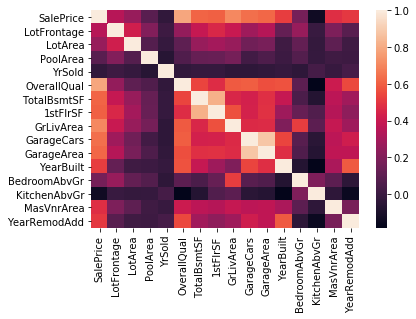

In [6]:
sns.heatmap(train_set[suspects].corr())

In [7]:
train_set[suspects].corr()

,SalePrice,LotFrontage,LotArea,PoolArea,YrSold,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea,YearBuilt,BedroomAbvGr,KitchenAbvGr,MasVnrArea,YearRemodAdd
SalePrice,1.000000,0.351799,0.263843,0.092404,-0.028923,0.790982,0.613581,0.605852,0.708624,0.640409,0.623431,0.522897,0.168213,-0.135907,0.477493,0.507101
LotFrontage,0.351799,1.000000,0.426095,0.206167,0.007450,0.251646,0.392075,0.457181,0.402797,0.285691,0.344997,0.123349,0.263170,-0.006069,0.193458,0.088866
LotArea,0.263843,0.426095,1.000000,0.077672,-0.014261,0.105806,0.260833,0.299475,0.263116,0.154871,0.180403,0.014228,0.119690,-0.017784,0.104160,0.013788
PoolArea,0.092404,0.206167,0.077672,1.000000,-0.059689,0.065166,0.126053,0.131525,0.170205,0.020934,0.061047,0.004950,0.070703,-0.014525,0.011723,0.005829
YrSold,-0.028923,0.007450,-0.014261,-0.059689,1.000000,-0.027347,-0.014969,-0.013604,-0.036526,-0.039117,-0.027378,-0.013618,-0.036014,0.031687,-0.008201,0.035743
OverallQual,0.790982,0.251646,0.105806,0.065166,-0.027347,1.000000,0.537808,0.476224,0.593007,0.600671,0.562022,0.572323,0.101676,-0.183882,0.411876,0.550684
TotalBsmtSF,0.613581,0.392075,0.260833,0.126053,-0.014969,0.537808,1.000000,0.819530,0.454868,0.434585,0.486665,0.391452,0.050450,-0.068901,0.363936,0.291066
1stFlrSF,0.605852,0.457181,0.299475,0.131525,-0.013604,0.476224,0.819530,1.000000,0.566024,0.439317,0.489782,0.281986,0.127401,0.068101,0.344501,0.240379
GrLivArea,0.708624,0.402797,0.263116,0.170205,-0.036526,0.593007,0.454868,0.566024,1.000000,0.467247,0.468997,0.199010,0.521270,0.100063,0.390857,0.287389
GarageCars,0.640409,0.285691,0.154871,0.020934,-0.039117,0.600671,0.434585,0.439317,0.467247,1.000000,0.882475,0.537850,0.086106,-0.050634,0.364204,0.420622


## Conclusion (11 features):
1.  Correlated features with SalePrice from highest to lowest order SalesPrivce vs All... </br>
    a. Overall quality of material (OverallQual, 0.79) </br>
    b. Above grade living area in square feet (GrLivArea, 0.70) </br>
    c. Size of garage in car capacity (GarageCars, 0.64) </br>
    d. Size of garage in square feet (GarageArea, 0.62) </br>
    e. Total basement area in square feet (TotalBsmtSF, 0.61)</br>
    f. First Floor area in square feet (1stFlrSF, 0.60) </br>
2. Overall quality of the house is highly correlated to the year it was built, the newer the house higher its quality (0.57)
3. Overall quality of the house is highly correlated to the year it was remodeled, most recent modeled house has higher quality (0.55)
4. Overall quality of the house is highly correlated to the garage cars capacity, the more cars a house can manage higher its quality (0.60)
5. Lot frontage (linear feet of street connected to house) is correlated with Lot Area (lot area in sq. feet around the house) (0.42)

## Task 2
Produce five other informative plots revealing aspects of this data. For each plot, write a paragraph in your notebook describing what interesting properties your visualization reveals. These must include: </br>
1. at least one line chart </br>
2. at least one scatter plot or data map </br>
3. at least one histogram or bar chart </br>


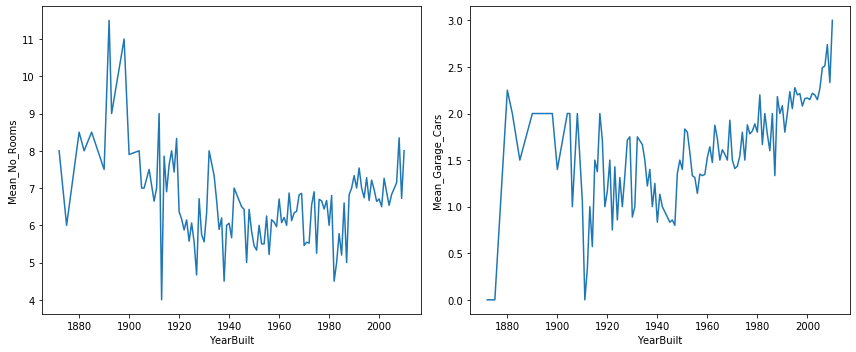

In [79]:
figures, axes = plt.subplots(1, 2, figsize=(12,5))

# TotRmsAbvGrd
totalRoomsYearAgg = train_set.groupby(["YearBuilt"])["TotRmsAbvGrd"].agg(["mean"]).reset_index()
totalRoomsYearAgg = totalRoomsYearAgg.rename(columns={"mean": "Mean_No_Rooms"})
sns.lineplot(x="YearBuilt", y="Mean_No_Rooms", data=totalRoomsYearAgg, markers=True, ax=axes[0])

# GarageCars

garageCarsYearAgg = train_set.groupby(["YearBuilt"])["GarageCars"].agg(["mean"]).reset_index()
garageCarsYearAgg = garageCarsYearAgg.rename(columns={"mean": "Mean_Garage_Cars"})
sns.lineplot(x="YearBuilt", y="Mean_Garage_Cars", data=garageCarsYearAgg, markers=True, ax=axes[1])

plt.tight_layout()

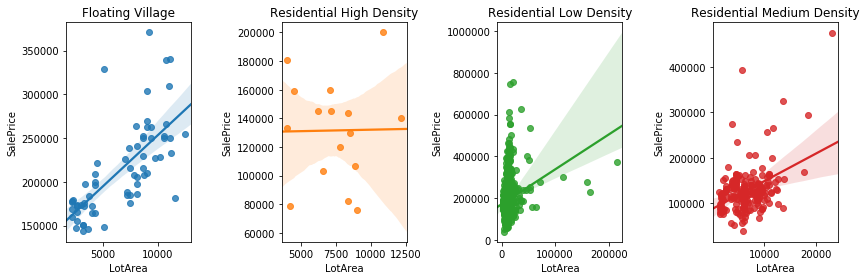

In [109]:
figures, axes = plt.subplots(1, 4, figsize=(12,4))
residency_types = ['FV', 'RH','RL','RM']
labels = ["Floating Village", "Residential High Density", "Residential Low Density", "Residential Medium Density"]
for index, residency_type in enumerate(residency_types):
    residency = train_set[train_set.MSZoning == residency_type]
    sns.regplot(x='LotArea', y='SalePrice', data=residency, ax=axes[index])
    axes[index].set_title(labels[index])

plt.tight_layout()

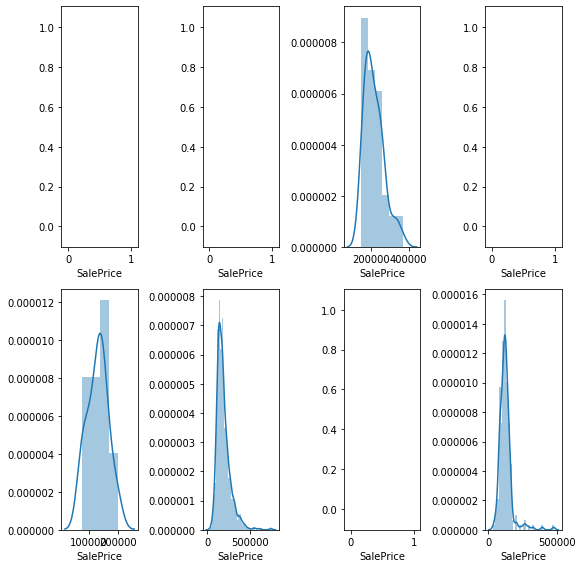

In [122]:

residency_types = [['A', 'C', 'FV', 'I'], ['RH','RL', 'RP','RM']]
figures, axes = plt.subplots(2, 4, figsize=(8,8))
# labels = ["Floating Village", "Residential High Density", "Residential Low Density", "Residential Medium Density"]
for index, type_set in enumerate(residency_types):
    for j, residency_type in enumerate(type_set):
        residency = train_set[train_set.MSZoning == residency_type]
        sns.distplot(residency.SalePrice, ax=axes[index][j])
# sns.distplot(train_set.LotArea, bins=1000)
#     sns.regplot(x='LotArea', y='SalePrice', data=residency, ax=axes[index])
#     axes[index].set_title(labels[index])
plt.tight_layout()